In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load provided dataset
data = pd.read_csv(r"C:\Users\KINYUA\Downloads\QVI_data.csv", parse_dates =['DATE'])

In [3]:
# Explore columns
data.columns


Index(['LYLTY_CARD_NBR', 'DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE',
       'PREMIUM_CUSTOMER'],
      dtype='object')

In [4]:
# Rename columns

data.rename(columns={'LYLTY_CARD_NBR':'loyalty_card_no', 'DATE':'date', 'STORE_NBR':'store_no', 
'TXN_ID':'transaction_id', 'PROD_NBR':'product_no','PROD_NAME':'product_name', 'PROD_QTY':'product_qty', 
'TOT_SALES':'total_sales', 'PACK_SIZE':'pack_size', 'BRAND':'brand', 'LIFESTAGE':'lifestage',
       'PREMIUM_CUSTOMER':'premium_customer'}, inplace = True)

In [5]:
# Check data types
data.dtypes

loyalty_card_no              int64
date                datetime64[ns]
store_no                     int64
transaction_id               int64
product_no                   int64
product_name                object
product_qty                  int64
total_sales                float64
pack_size                    int64
brand                       object
lifestage                   object
premium_customer            object
dtype: object

In [6]:
# Add month column in the form yyyymm

data['year_month'] = data['date'].dt.strftime('%Y%m')

In [7]:
# Create measures over time for each store and month
measure_over_time = data.groupby(["store_no", "year_month"]).agg(
    totSales=("total_sales",'sum'),
    nCustomers=("loyalty_card_no", 'nunique'),
    nTxns = ('transaction_id', 'nunique'),
    nChips = ('product_qty', 'sum')
)
measure_over_time['nTxnsPerCust']  = measure_over_time["nTxns"]/ measure_over_time["nCustomers"]
measure_over_time['nChipsPerTxn'] = measure_over_time["nChips"] / measure_over_time["nTxns"]
measure_over_time['avgPricePerUnit'] = measure_over_time['totSales'] / measure_over_time['nChips']
measure_over_time_df = measure_over_time.drop(["nTxns", 'nChips'], axis=1).reset_index()


In [8]:
# Check the df

measure_over_time_df.head()

,store_no,year_month,totSales,nCustomers,nTxnsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [9]:
# Filter measures df for stores with full observations, ie, KPIs for 12 months

stores_with_full_obs = measure_over_time_df[measure_over_time_df['store_no'].isin(measure_over_time_df
    ['store_no'].value_counts().index[measure_over_time_df['store_no'].value_counts() == 12])]

# Extract data for stores with full observations for the pre-trial period

pre_trial_measures = stores_with_full_obs[stores_with_full_obs['year_month'] < '201902']

In [10]:
# Identify stores that are closely related to the test stores to serve as control by calculating 
# correlation coeefficients. Best control store one with the highest correlation on sales, customers,
# and any other chosen metric

def calculate_correlation(metric):
    
    #Initialize results list
    
    corr_result = []
    
    # loop over trial and control store args
    
    for trial_store in trial_stores:
        for control_store in control_stores:
            
            trial_store_df = pd.DataFrame(pre_trial_measures[pre_trial_measures["store_no"]==trial_store][
                                          ["year_month",metric]])
            control_store_df = pd.DataFrame(pre_trial_measures[pre_trial_measures["store_no"]==control_store]
                                [["year_month", metric]])
            # merge control and trial store on each trial, control store, and metric comparison
            merged_df = pd.merge(trial_store_df, control_store_df, on="year_month", suffixes=['_trial',
                                                                                              '_control'])
            
            # Calculate correlation coefficient for trial and control on each metric
            correlation = merged_df[metric + '_trial'].corr(merged_df[metric +'_control'])
            
            # Append iterations to initiatilised result list
            corr_result.append([trial_store, control_store, metric, correlation])
            
            # Convert list to a df and rename columns
    result = pd.DataFrame(corr_result, columns=["trial_store", "control_store",'kpi','correlation'],
                          index =range(len(corr_result)))
    
    return result
        


In [11]:

# Create a function to calculate magnitude distance

def calculate_magnitude_distance(metric):
    
    distance_table = []
    
    for trial_store in trial_stores:
        for control_store in control_stores:
            
            # Extract monthly metric data for trial store
            
            trial_df = pre_trial_measures[pre_trial_measures["store_no"]==trial_store][["year_month", metric]] 
            
            # Extract monthly metric data for control store
            control_df = pre_trial_measures[pre_trial_measures["store_no"]==control_store][["year_month", metric]]
            
            # Merge trial and control store into one df
            merged_df = pd.merge(trial_df, control_df, how='left', on="year_month", suffixes=['_trial', '_control'])
            
            # Calculate magnitude distance for the metric
            for index, row in merged_df.iterrows():
                magnitude_measure = abs(row[metric + '_trial'] - row[metric + '_control'])
        
                # Append trial and control stores, month and measure to initialized list
                distance_table.append([trial_store, control_store, row['year_month'], magnitude_measure])
            
        # Convert list into a df, remaming columns
        measures = pd.DataFrame(distance_table, columns=["trial_store", 'control_store', 'year_month', 'measure'], 
                            index=range(len(distance_table)))
    
# MinMax scaling

    # Calculate minimum and maximum distances for each store and month
    min_max_distance = measures.groupby(["trial_store", 'year_month'])['measure'].agg(['min', 'max']).reset_index()
    
    # Merge min and max distances to measures df
    
    measures_min_max = pd.merge(measures, min_max_distance, on =['trial_store', 'year_month'])
    
    # Add standardized distance as magnitude_measure
    
    measures_min_max["magnitude_measure"] = 1-(measures_min_max['measure']- measures_min_max['min']) / \
                                                (measures_min_max['max']- measures_min_max['min'])
    
    # Calculate aggregate (store1 and store2) magnitude measure
    
    final_distance_table = measures_min_max.groupby(['trial_store', 'control_store'])['magnitude_measure'].mean(
                                                        ).reset_index()
    
    return final_distance_table



In [12]:
# Obtain best matched control store for trial store 77

# Calculate correlations for total sales and number of customers for store 77

trial_stores = [77]
control_stores = list(pre_trial_measures['store_no'].unique()) 

# Applying functions

corr_sales = calculate_correlation("totSales")
corr_customers = calculate_correlation("nCustomers")

# Calculate magnitude distance for total sales and number of customers for store 77

magnitude_sales = calculate_magnitude_distance("totSales")
magnitude_customers = calculate_magnitude_distance("nCustomers")

# Create a combined correlation and magnitude distance score for sales

corr_magnitude_sales= pd.merge(corr_sales, magnitude_sales, on =['trial_store', 'control_store'])
corr_magnitude_sales['corr_mag_sales'] = corr_magnitude_sales['correlation']*0.5 + \
                                        corr_magnitude_sales['magnitude_measure']*0.5

# Create a combined correlation and magnitude distance for customers
corr_magnitude_customers = pd.merge(corr_customers, magnitude_customers, on=['trial_store', 'control_store'])
corr_magnitude_customers['corr_mag_customers'] = corr_magnitude_customers['correlation']*0.5 + \
                                                    corr_magnitude_customers['magnitude_measure']*0.5

# Create a combined sales and customers measures table and calculate an average of the correlation and 
# magnitude scores
score_control = pd.merge(corr_magnitude_sales, corr_magnitude_customers, on=['trial_store', 'control_store'])[
                                      ['trial_store', 'control_store', 'corr_mag_sales','corr_mag_customers']]
score_control['final_control_score'] = score_control['corr_mag_customers'] * 0.5 + \
                                                            score_control['corr_mag_sales']*0.5
# Control store is the store with the highest final score, relative to the trial store
score_control.sort_values(by='final_control_score', ascending=False).head(2)

,trial_store,control_store,corr_mag_sales,corr_mag_customers,final_control_score
72,77,77,1.00000,1.000000,1.000000
221,77,233,0.94452,0.991566,0.968043


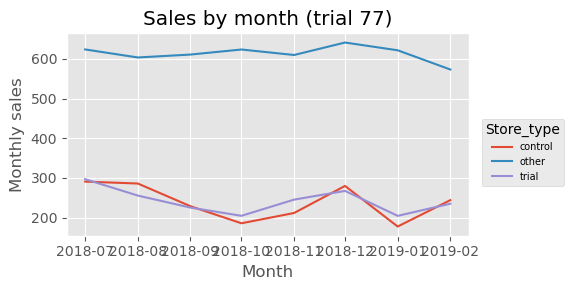

In [13]:
# Visualize the selection of store 233 as similar to trial store 77

# Create categorical column for store_type with values trial, control, and other stores.

measure_over_time_trial77 = measure_over_time_df.copy()
measure_over_time_trial77['store_type'] = np.select(
    [measure_over_time_trial77['store_no'] == 77,
     measure_over_time_trial77['store_no'] == 233],
    ['trial', 'control'],
    default ='other'
)
# Convert date dtype to datetime

measure_over_time_trial77['year_month'] = pd.to_datetime(measure_over_time_trial77['year_month'], 
                                                         format='%Y%m')

# Remove values for periods during and after trial period

pre_trial_sales = measure_over_time_trial77[measure_over_time_trial77['year_month'] < '2019-03-01']

# Calculate the mean of sales of other stores

pre_trial_sales_df = pre_trial_sales.groupby(['store_type', 'year_month'])['totSales'].mean()\
                                                                        .reset_index()

# Plot trial, control, and mean sales

plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(6,3))

for store_type, group in pre_trial_sales_df.groupby('store_type'):
    ax.plot(group['year_month'], group['totSales'], label=store_type) 

ax.set_xlabel("Month")
ax.set_ylabel("Monthly sales")
ax.set_title("Sales by month (trial 77)")
plt.legend(bbox_to_anchor =(1.25, 0.6), fontsize=7, title='Store_type')
plt.tight_layout()

plt.show()



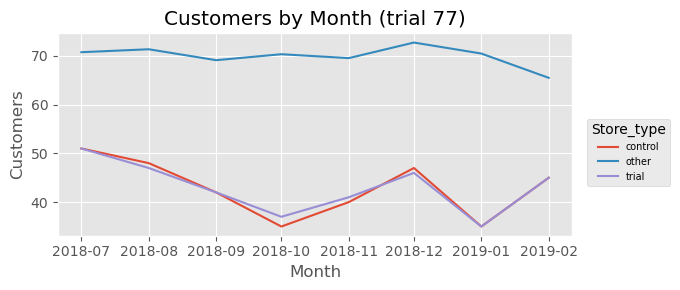

In [15]:
# Plot trial, control, and other stores customers in the pre_trial_period

customers_over_time = measure_over_time_trial77.groupby(['store_type', 'year_month'])['nCustomers'].mean()\
                     .reset_index()
pre_trial_customers = customers_over_time[customers_over_time['year_month'] < '2019-03-01']

fig, ax = plt.subplots(figsize=(6,3))

for store_type, group in pre_trial_customers.groupby('store_type'):
    plt.plot(group['year_month'], group['nCustomers'], label=store_type)
plt.title("Customers by Month (trial 77)")
plt.xlabel("Month")
plt.ylabel("Customers")
plt.tight_layout()
plt.legend(bbox_to_anchor= (1.2, 0.6), title='Store_type', fontsize=7)

plt.show()

#### Assess the Impact of Trial 77 on Sales and Customers


In [17]:
# Scale control stores sales to smooth out differences outside the trial period
# Calculate scaling factor

scaling_factor = (measure_over_time_df[(measure_over_time_df['store_no']==77) & (measure_over_time_df['year_month'] < 
                '201902')]['totSales'].sum()) / (measure_over_time_df[(measure_over_time_df['store_no']==233) & 
                (measure_over_time_df['year_month'] < '201902')]['totSales'].sum())

# Calculate control sales by multiplying sales with the scaling factor.

scaled_control_sales = pd.DataFrame({
    'control_sales': measure_over_time_df[measure_over_time_df["store_no"]==233]['totSales']*scaling_factor,
    'store_no':233,
    'year_month': measure_over_time_df['year_month'].unique()})

scaled_control_sales_df = pd.merge(scaled_control_sales, measure_over_time_df[measure_over_time_df['store_no']==77], 
                                   on = 'year_month', suffixes=['_control', '_trial'])
scaled_control_sales_df['percent_diff'] = abs((scaled_control_sales_df['control_sales']-
                                             scaled_control_sales_df['totSales']) /
                                             scaled_control_sales_df['control_sales'])

# Calculate standard deviation to assess significant difference

std_dev = scaled_control_sales_df[scaled_control_sales_df['year_month'] < '201902']['percent_diff'].std()
print("standard deviation: ", std_dev)

# Calculate t-values for the percent_diff in the trial period

t_value_percent_diff = pd.DataFrame({
    "transaction_month": pd.to_datetime((scaled_control_sales_df[scaled_control_sales_df['year_month'].between(
        '201902', '201904', inclusive='both')]['year_month']), format='%Y%m'),
    't_value': scaled_control_sales_df[scaled_control_sales_df['year_month'].between(
        '201902', '201904', inclusive='both')]['percent_diff'].apply(lambda x: x/std_dev)
}).reset_index(drop=True)
print(t_value_percent_diff)
     
# Calculate the critical value for a right-tailed distribution of the percent_diff at 95% confidence to check
# if the t_values are significant

critical_t_value = st.t.ppf(0.95, 7)
print("Upper_bound: ", critical_t_value)

# The difference in sales between control and trial was significant in two of the three months during the trial:
# March and April 2019 as the t statistic lies significantly outside the critical region.



standard deviation:  0.04994076264142537
  transaction_month    t_value
0        2019-02-01   1.183534
1        2019-03-01   7.339116
2        2019-04-01  12.476373
Upper_bound:  1.894578605061305


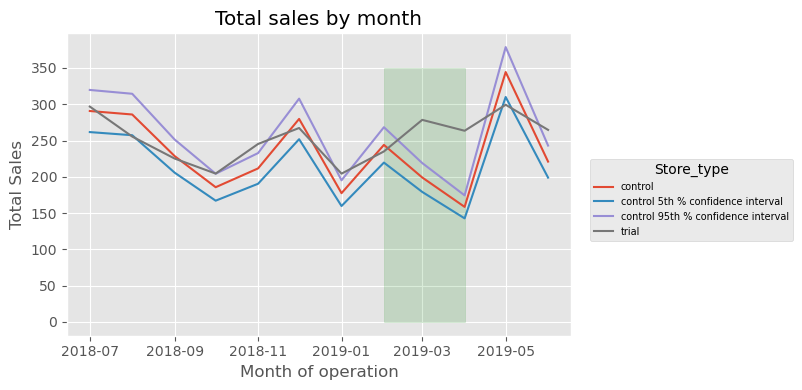

In [18]:
# Plot sales for trial store and 95% and 5% percentile for control to visualize the difference in sales

past_sales = measure_over_time_df.drop(['nCustomers', 'nTxnsPerCust','nChipsPerTxn', 
                                     'avgPricePerUnit'], axis=1)
# Insert store_type column

past_sales['store_type'] = np.select(
    [
        past_sales['store_no'] ==77,
        past_sales['store_no'] ==233
    ],
    ['trial', 'control'],
    default= 'other stores'
)

# Drop store_no column

past_sales = past_sales.drop("store_no", axis=1)

# Remove other stores 
past_sales = past_sales.loc[past_sales['store_type']!="other stores"]

# Change year_month dtype to datetime
past_sales['year_month'] = pd.to_datetime(past_sales['year_month'], format='%Y%m')

# Create 95th percentile sales for control store
ninety_fifth_percentile =pd.DataFrame({
    "store_type": "control 95th % confidence interval",
    "totSales": past_sales[past_sales["store_type"] == 'control']['totSales']*(1 +  std_dev*2),
    "year_month": past_sales[past_sales["store_type"] == 'control']['year_month'].unique()
})

# Create 5th percentile sales for control store
fifth_percentile = pd.DataFrame({
    "store_type": "control 5th % confidence interval",
     "totSales": past_sales[past_sales["store_type"] == 'control']['totSales']*(1 -  std_dev*2),
     "year_month": past_sales[past_sales["store_type"] == 'control']['year_month'].unique()
})

# Join the three dfs to create one df for plotting

past_sales_df = pd.concat([past_sales, ninety_fifth_percentile, fifth_percentile])

# Plot trial, control, and 95th and 5th percentile of the control store

from matplotlib.patches import Rectangle

rect = Rectangle((pd.to_datetime('2019-02-01'), 0), 
        width=pd.to_datetime('2019-04-01') - pd.to_datetime('2019-02-01'), 
        height=350, color='g', alpha=0.15)


fig, ax = plt.subplots(figsize=(9, 4))

for store_type, group in past_sales_df.groupby("store_type"):
    ax.plot(group["year_month"], group['totSales'], label = store_type)
ax.set_xlabel("Month of operation")
ax.set_ylabel("Total Sales")
ax.set_title("Total sales by month")
plt.legend(bbox_to_anchor=(1.45, 0.6), title="Store_type", fontsize=7)
plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()


# The plot shows trial store 77 is significantly different from its control (store 233) as its average monthly
# sales exceed the 95th percentile of comparator store in two of the three months in the trial period.

In [20]:
# Check the difference in the number of customers for trial 77 against its matched control 233

# Scale control stores customers to smooth out differences outside the trial period
# Calculate scaling factor
scaling_factor = measure_over_time_df[(measure_over_time_df['store_no']==77) & (measure_over_time_df['year_month'] < 
                '201902')]['nCustomers'].sum() / measure_over_time_df[(measure_over_time_df['store_no']==233) & 
                (measure_over_time_df['year_month'] < '201902')]['nCustomers'].sum()

# Calculate control customers by multiplying customers with the scaling factor.

scaled_control_customers = pd.DataFrame({
    'control_customers': measure_over_time_df[measure_over_time_df["store_no"]==233]['nCustomers']*scaling_factor,
    'store_no':233,
    'year_month': measure_over_time_df['year_month'].unique()})

scaled_control_customers_df = pd.merge(scaled_control_customers, measure_over_time_df[measure_over_time_df['store_no']==77], 
                                   on = 'year_month', suffixes=['_control', '_trial'])[['year_month', 
                                   'store_no_trial', 'nCustomers', 'store_no_control', 'control_customers']]
scaled_control_customers_df['percent_diff'] = abs((scaled_control_customers_df['control_customers']-
                                             scaled_control_customers_df['nCustomers']) /
                                             scaled_control_customers_df['control_customers'])

# Calculate standard deviation to assess significant difference

std_dev = scaled_control_customers_df[scaled_control_customers_df['year_month'] < '201902']['percent_diff'].std()
print("standard deviation: ", std_dev)

# Calculate t-values for the percent_diff in the trial period

t_value_percent_diff = pd.DataFrame({
    "transaction_month": pd.to_datetime((scaled_control_customers_df[scaled_control_customers_df['year_month'].between(
        '201902', '201904', inclusive='both')]['year_month']).astype(str), format='%Y%m'),
    't_value': scaled_control_customers_df[scaled_control_customers_df['year_month'].between(
        '201902', '201904', inclusive='both')]['percent_diff'].apply(lambda x: x/std_dev)
}).reset_index(drop=True)
print(t_value_percent_diff)

# Calculate the critical value for a right-tailed distribution of the percent_diff at 95% confidence to check
# if the t_values are significant

critical_t_value = st.t.ppf(0.95, 7)
print("Upper_bound: ", critical_t_value)

# The difference in customers between control and trial was significant in two of the three months during the trial:
# March and April 2019 as the t statistic lies significantly outside the critical region.


standard deviation:  0.01824074855824395
  transaction_month    t_value
0        2019-02-01   0.183352
1        2019-03-01  13.476388
2        2019-04-01  30.778725
Upper_bound:  1.894578605061305


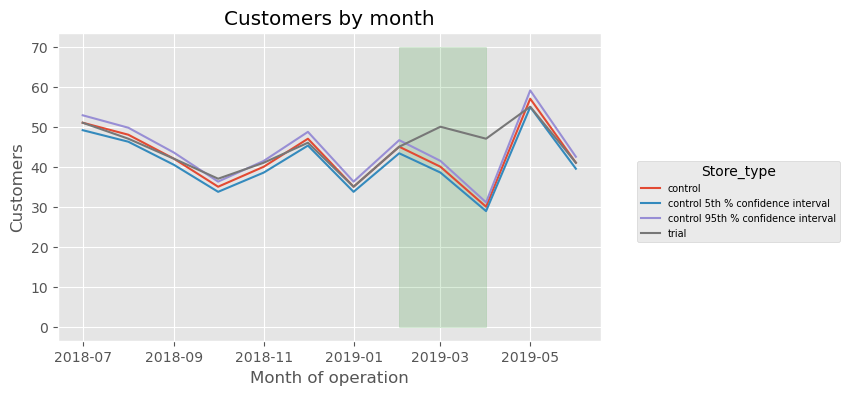

In [21]:
# Plot customers for trial store and 95% and 5% CI for control to visualize the difference in customers

past_customers = measure_over_time_df.drop(['totSales', 'nTxnsPerCust','nChipsPerTxn', 
                                     'avgPricePerUnit'], axis=1)
# Insert store_type column

past_customers['store_type'] = np.select(
    [
        past_customers['store_no'] ==77,
        past_customers['store_no'] ==233
    ],
    ['trial', 'control'],
    default= 'other stores'
)

# Drop store_no column

past_customers = past_customers.drop("store_no", axis=1)

# Remove other stores 
past_customers = past_customers.loc[past_customers['store_type']!="other stores"]

# Change year_month dtype to datetime
past_customers['year_month'] = pd.to_datetime(past_customers['year_month'], format='%Y%m')

# Create 95th percentile sales for control store
ninety_fifth_percentile = pd.DataFrame({
    "store_type": "control 95th % confidence interval",
    "nCustomers": past_customers[past_customers["store_type"] == 'control']['nCustomers']*(1 +  std_dev*2),
    "year_month":past_customers[past_customers["store_type"] == 'control']['year_month'].unique()
})

# Create 5th percentile sales for control store
fifth_percentile = pd.DataFrame({
     "store_type": "control 5th % confidence interval",
     "nCustomers": past_customers[past_customers["store_type"] == 'control']['nCustomers']*(1 -  std_dev*2),
     "year_month": past_customers[past_customers["store_type"] == 'control']['year_month'].unique()
})

# Join the three dfs to create one df for plotting

past_customers_df = pd.concat([past_customers, ninety_fifth_percentile, fifth_percentile])

# Plot trial, control, and 95th and 5th percentile of the control store

from matplotlib.patches import Rectangle

rect = Rectangle((pd.to_datetime('2019-02-01'), 0), 
        width=pd.to_datetime('2019-04-01') - pd.to_datetime('2019-02-01'), 
        height=70, color='g', alpha=0.15)


fig, ax = plt.subplots(figsize=(7, 4))

for store_type, group in past_customers_df.groupby("store_type"):
    ax.plot(group["year_month"], group['nCustomers'], label = store_type)
ax.set_xlabel("Month of operation")
ax.set_ylabel("Customers")
ax.set_title("Customers by month")
plt.legend(bbox_to_anchor=(1.45, 0.6), title="Store_type", fontsize=7)
plt.gca().add_patch(rect)

plt.show()


# The plot shows trial store 77 is significantly different from its control (store 233) as its average monthly
# customers exceed the 95th percentile of comparator store in two of the three months in the trial period.

## Trial 86 

In [22]:
# Obtain best matched control store for trial store 86

# Calculate correlations for total sales and number of customers for store 86

trial_stores = [86]
control_stores = list(pre_trial_measures['store_no'].unique())

#Applying functions

corr_sales = calculate_correlation("totSales")
corr_customers = calculate_correlation("nCustomers")

# Calculate magnitude distance for total sales and number of customers for store 77

magnitude_sales = calculate_magnitude_distance("totSales")
magnitude_customers = calculate_magnitude_distance("nCustomers")

# Create a combined correlation and magnitude distance score for sales

corr_magnitude_sales= pd.merge(corr_sales, magnitude_sales, on =['trial_store', 'control_store'])
corr_magnitude_sales['corr_mag_sales'] = corr_magnitude_sales['correlation']*0.5 + \
                                        corr_magnitude_sales['magnitude_measure']*0.5

# Create a combined correlation and magnitude distance for customers
corr_magnitude_customers = pd.merge(corr_customers, magnitude_customers, on=['trial_store', 'control_store'])
corr_magnitude_customers['corr_mag_customers'] = corr_magnitude_customers['correlation']*0.5 + \
                                                    corr_magnitude_customers['magnitude_measure']*0.5

# Create a combined sales and customers measures table and calculate an average of the correlation and 
# magnitude scores
score_control = pd.merge(corr_magnitude_sales, corr_magnitude_customers, on=['trial_store', 'control_store'])[
                                      ['trial_store', 'control_store', 'corr_mag_sales','corr_mag_customers']]
score_control['final_control_score'] = score_control['corr_mag_customers'] * 0.5 + \
                                                            score_control['corr_mag_sales']*0.5
# Control store is the store with the highest final score
score_control.sort_values(by='final_control_score', ascending=False).head(2)

,trial_store,control_store,corr_mag_sales,corr_mag_customers,final_control_score
80,86,86,1.000000,1.000000,1.00000
147,86,155,0.920423,0.963956,0.94219


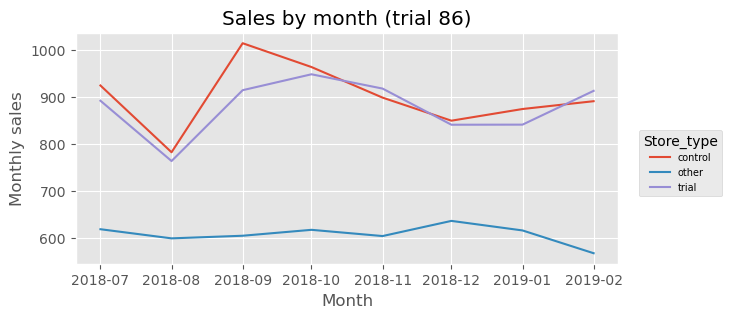

In [23]:
# View the selection by plotting sales and customers for the trial, control, and other stores
# 1. Sales
# Create categorical column for store_type with values trial, control, and other stores.

measure_over_time_trial86 = measure_over_time_df.copy()
measure_over_time_trial86['store_type'] = np.select(
    [measure_over_time_trial86['store_no'] == 86,
     measure_over_time_trial86['store_no'] == 155],
    ['trial', 'control'],
    default ='other'
)
# Convert date dtype to datetime

measure_over_time_trial86['year_month'] = pd.to_datetime(measure_over_time_trial86['year_month'], 
                                                         format='%Y%m')

# Remove values for periods during and after trial period

pre_trial_sales = measure_over_time_trial86[measure_over_time_trial86['year_month'] < '2019-03-01']

# Calculate the mean of sales of other stores

pre_trial_sales_df = pre_trial_sales.groupby(['store_type', 'year_month'])['totSales'].mean()\
                                                                        .reset_index()

# Plot trial, control, and mean sales

plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(7,3))

for store_type, group in pre_trial_sales_df.groupby('store_type'):
    ax.plot(group['year_month'], group['totSales'], label=store_type) 

ax.set_xlabel("Month")
ax.set_ylabel("Monthly sales")
ax.set_title("Sales by month (trial 86)")

plt.legend(bbox_to_anchor =(1.2, 0.6), fontsize=7, title='Store_type')

plt.show()


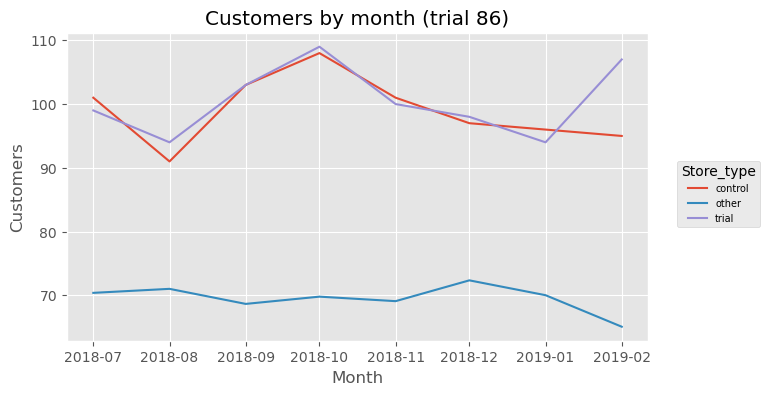

In [24]:
# 2. Customers

pre_trial_customers = pre_trial_sales.groupby(['store_type', 'year_month'])['nCustomers'].mean()\
                                                                                .reset_index()

fig, ax = plt.subplots(figsize=(7.5, 4))

for store_type, group in pre_trial_customers.groupby('store_type'):
    ax.plot(group['year_month'], group['nCustomers'], label=store_type)
    
ax.set_title("Customers by month (trial 86)")
ax.set_xlabel("Month")
ax.set_ylabel("Customers")
plt.legend(bbox_to_anchor = (1.2, 0.6), title='Store_type', fontsize=7)

plt.show()


#### Assess the Impact of the Trial 86 on Sales and Customers 

In [25]:
# Check the difference in the number of customers for trial 86 against its matched control 155
# Null hypothesis: No differences in the trial store sales and the control

# 1. Sales

# Scale control stores customers to smooth out differences outside the trial period
# Calculate scaling factor

scaling_factor = (measure_over_time_df[(measure_over_time_df['store_no']==86) & (measure_over_time_df['year_month'] < 
                '201902')]['totSales'].sum()) / (measure_over_time_df[(measure_over_time_df['store_no']==155) & 
                (measure_over_time_df['year_month'] < '201902')]['totSales'].sum())

# Calculate control sales by multiplying sales with the scaling factor.

scaled_control_sales = pd.DataFrame({
    'control_sales': measure_over_time_df[measure_over_time_df["store_no"]==155]['totSales']*scaling_factor,
    'store_no':155,
    'year_month': measure_over_time_df['year_month'].unique()})

scaled_control_sales_df = pd.merge(scaled_control_sales, measure_over_time_df[measure_over_time_df['store_no']==86], 
                                   on = 'year_month', suffixes=['_control', '_trial'])
scaled_control_sales_df['percent_diff'] = abs((scaled_control_sales_df['control_sales']-
                                             scaled_control_sales_df['totSales']) /
                                             scaled_control_sales_df['control_sales'])

# Calculate standard deviation to assess significant difference

std_dev = scaled_control_sales_df[scaled_control_sales_df['year_month'] < '201902']['percent_diff'].std()
print("standard deviation: ", std_dev)

# Calculate t-values for the percent_diff in the trial period

t_value_percent_diff = pd.DataFrame({
    "transaction_month": pd.to_datetime((scaled_control_sales_df[scaled_control_sales_df['year_month'].between(
        '201902', '201904', inclusive='both')]['year_month']), format='%Y%m'),
    't_value': scaled_control_sales_df[scaled_control_sales_df['year_month'].between(
        '201902', '201904', inclusive='both')]['percent_diff'].apply(lambda x: x/std_dev)
}).reset_index(drop=True)
print(t_value_percent_diff)
     
# Calculate the critical value for a right-tailed distribution of the percent_diff at 95% confidence to check
# if the t_values are significant

critical_t_value = st.t.ppf(0.95, 7)
print("Upper_bound: ", critical_t_value)

# The difference is sales between control and trial was not significant in two of the three months during the trial:
# as the t statistic is within the critical region in February and March.


standard deviation:  0.025833952854772368
  transaction_month    t_value
0        2019-02-01   2.179542
1        2019-03-01  12.226922
2        2019-04-01   1.364580
Upper_bound:  1.894578605061305


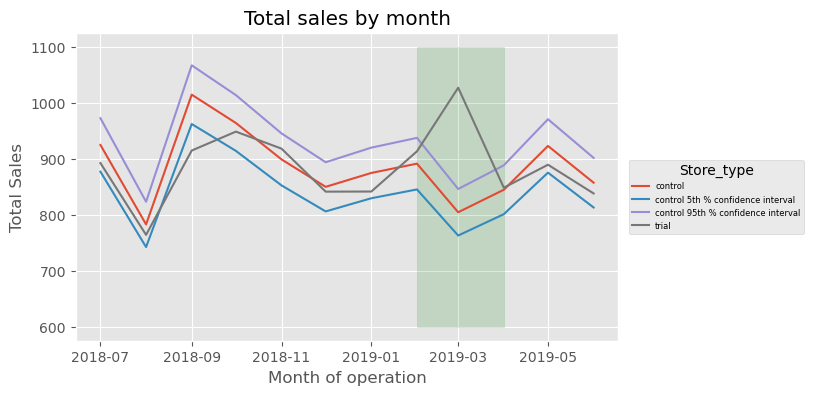

In [26]:
# Plot the sales for trial against the 95th and 5th percentile of the control to visualize differences

past_sales = measure_over_time_df.drop(['nCustomers', 'nTxnsPerCust','nChipsPerTxn', 
                                     'avgPricePerUnit'], axis=1)
# Insert store_type column
past_sales['store_type'] = np.select(
    [
        past_sales['store_no'] ==86,
        past_sales['store_no'] ==155
    ],
    ['trial', 'control'],
    default= 'other stores'
)

# Drop store_no column

past_sales = past_sales.drop("store_no", axis=1)

# Remove other stores 
past_sales = past_sales.loc[past_sales['store_type']!="other stores"]

# Change year_month dtype to datetime
past_sales['year_month'] = pd.to_datetime(past_sales['year_month'], format='%Y%m')

# Create 95th percentile sales for control store
ninety_fifth_percentile =pd.DataFrame({
    "store_type": "control 95th % confidence interval",
    "totSales": past_sales[past_sales["store_type"] == 'control']['totSales']*(1 +  std_dev*2),
    "year_month": past_sales[past_sales["store_type"] == 'control']['year_month'].unique()
})

# Create 5th percentile sales for control store
fifth_percentile = pd.DataFrame({
    "store_type": "control 5th % confidence interval",
     "totSales": past_sales[past_sales["store_type"] == 'control']['totSales']*(1 -  std_dev*2),
     "year_month": past_sales[past_sales["store_type"] == 'control']['year_month'].unique()
})

# Join the three dfs to create one df for plotting

past_sales_df = pd.concat([past_sales, ninety_fifth_percentile, fifth_percentile])

# Plot trial, control, and 95th and 5th percentile of the control store

from matplotlib.patches import Rectangle

rect = Rectangle((pd.to_datetime('2019-02-01'), 600), 
        width=pd.to_datetime('2019-04-01') - pd.to_datetime('2019-02-01'), 
        height=500, color='g', alpha=0.15)


fig, ax = plt.subplots(figsize=(7, 4))

for store_type, group in past_sales_df.groupby("store_type"):
    ax.plot(group["year_month"], group['totSales'], label = store_type)
    
ax.set_xlabel("Month of operation")
ax.set_ylabel("Total Sales")
ax.set_title("Total sales by month")
plt.legend(bbox_to_anchor=(1.35, 0.6), title="Store_type", fontsize=6)
plt.gca().add_patch(rect)

plt.show()


# The plot shows trial store 86 is not significantly different from its control (store 155) as its average monthly
# sales exceed the 95th percentile of comparator store in only one of the three months in the trial period.





In [27]:
# Check the difference in the number of customers for trial 86 against its matched control 155
# Null hypothesis: No impact on sales and number of customers

# 2. Customers

# Scale control stores customers to smooth out differences outside the trial period

# Calculate scaling factor
scaling_factor = measure_over_time_df[(measure_over_time_df['store_no']==86) & (measure_over_time_df['year_month'] < 
                '201902')]['nCustomers'].sum() / measure_over_time_df[(measure_over_time_df['store_no']==155) & 
                (measure_over_time_df['year_month'] < '201902')]['nCustomers'].sum()

# Calculate control customers by multiplying customers with the scaling factor.

scaled_control_customers = pd.DataFrame({
    'control_customers': measure_over_time_df[measure_over_time_df["store_no"]==155]['nCustomers']*scaling_factor,
    'store_no':155,
    'year_month': measure_over_time_df['year_month'].unique()})

scaled_control_customers_df = pd.merge(scaled_control_customers, measure_over_time_df[measure_over_time_df['store_no']==86], 
                                   on = 'year_month', suffixes=['_control', '_trial'])
scaled_control_customers_df['percent_diff'] = abs((scaled_control_customers_df['control_customers']-
                                             scaled_control_customers_df['nCustomers']) /
                                             scaled_control_customers_df['control_customers'])

# Calculate standard deviation to assess significant difference

std_dev = scaled_control_customers_df[scaled_control_customers_df['year_month'] < '201902']['percent_diff'].std()
print("standard deviation: ", std_dev)

# Calculate t-values for the percent_diff in the trial period

t_value_percent_diff = pd.DataFrame({
    "transaction_month": pd.to_datetime((scaled_control_customers_df[scaled_control_customers_df['year_month'].between(
        '201902', '201904', inclusive='both')]['year_month']).astype(str), format='%Y%m'),
    't_value': scaled_control_customers_df[scaled_control_customers_df['year_month'].between(
        '201902', '201904', inclusive='both')]['percent_diff'].apply(lambda x: x/std_dev)
}).reset_index(drop=True)
print(t_value_percent_diff)

# Calculate the critical value for a right-tailed distribution of the percent_diff at 95% confidence to check
# if the t_values are significant

critical_t_value = st.t.ppf(0.95, 7)
print("Upper_bound: ", critical_t_value)

# The difference in customers between control and trial was significant in the three months during the trial:
# February, March and April 2019 as the t statistic is significantly outside the critical region.


standard deviation:  0.010687444701395238
  transaction_month    t_value
0        2019-02-01  11.819082
1        2019-03-01  20.903430
2        2019-04-01   5.670772
Upper_bound:  1.894578605061305


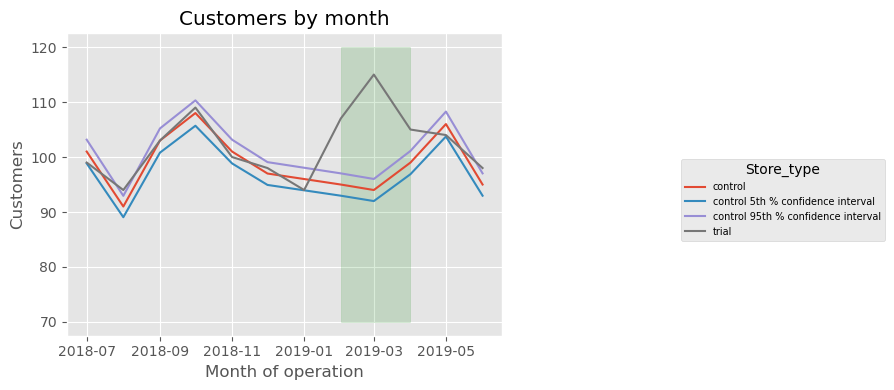

In [28]:
# Plot the customers for trial against the 95th and 5th percentile of the control to visualize differences

past_customers = measure_over_time_df.drop(['totSales', 'nTxnsPerCust','nChipsPerTxn', 
                                     'avgPricePerUnit'], axis=1)
# Insert store_type column
past_customers['store_type'] = np.select(
    [
        past_customers['store_no'] ==86,
        past_customers['store_no'] ==155
    ],
    ['trial', 'control'],
    default= 'other stores'
)

# Drop store_no column

past_customers = past_customers.drop("store_no", axis=1)

# Remove other stores 
past_customers = past_customers.loc[past_customers['store_type']!="other stores"]

# Change year_month dtype to datetime
past_customers['year_month'] = pd.to_datetime(past_customers['year_month'], format='%Y%m')

# Create 95th percentile sales for control store
ninety_fifth_percentile =pd.DataFrame({
    "store_type": "control 95th % confidence interval",
    "nCustomers": past_customers[past_customers["store_type"] == 'control']['nCustomers']*(1 +  std_dev*2),
    "year_month": past_customers[past_customers["store_type"] == 'control']['year_month'].unique()
})

# Create 5th percentile sales for control store
fifth_percentile = pd.DataFrame({
    "store_type": "control 5th % confidence interval",
     "nCustomers": past_customers[past_customers["store_type"] == 'control']['nCustomers']*(1 -  std_dev*2),
     "year_month": past_customers[past_customers["store_type"] == 'control']['year_month'].unique()
})

# Join the three dfs to create one df for plotting

past_customers_df = pd.concat([past_customers, ninety_fifth_percentile, fifth_percentile])

# Plot trial, control, and 95th and 5th percentile of the control store

from matplotlib.patches import Rectangle

rect = Rectangle((pd.to_datetime('2019-02-01'), 70), 
        width=pd.to_datetime('2019-04-01') - pd.to_datetime('2019-02-01'), 
        height= 50, color='g', alpha=0.15)


fig, ax = plt.subplots(figsize=(7.5, 4))

for store_type, group in past_customers_df.groupby("store_type"):
    ax.plot(group["year_month"], group['nCustomers'], label = store_type)
    
ax.set_xlabel("Month of operation")
ax.set_ylabel("Customers")
ax.set_title("Customers by month")
plt.legend(bbox_to_anchor=(1.40, 0.6), title="Store_type", fontsize=7)
plt.gca().add_patch(rect)
#plt.legend(title='', fontsize=7)
plt.tight_layout()
plt.show()


# The plot shows trial store 86 is significantly different from its control (store 155) as its average monthly
# customers exceed the 95th percentile of comparator store in all the three months in the trial period. However, 
# the increase in customers did not reflect in increased sales for all the three months. More information required
# to explain the anormally.




## Trial 88

In [30]:
# Obtain best matched control store for trial store 88

# Calculate correlations for total sales and number of customers for store 88

trial_stores = [88]
control_stores = list(pre_trial_measures['store_no'].unique())

corr_sales = calculate_correlation("totSales")
corr_customers = calculate_correlation("nCustomers")

# Calculate magnitude distance for total sales and number of customers for store 77

magnitude_sales = calculate_magnitude_distance("totSales")
magnitude_customers = calculate_magnitude_distance("nCustomers")

# Create a combined correlation and magnitude distance score for sales

corr_magnitude_sales= pd.merge(corr_sales, magnitude_sales, on =['trial_store', 'control_store'])
    
corr_magnitude_sales['corr_mag_sales'] = corr_magnitude_sales['correlation']*0.5 + \
                                        corr_magnitude_sales['magnitude_measure']*0.5

# Create a combined correlation and magnitude distance for customers
corr_magnitude_customers = pd.merge(corr_customers, magnitude_customers, on=['trial_store', 'control_store'])
corr_magnitude_customers['corr_mag_customers'] = corr_magnitude_customers['correlation']*0.5 + \
                                                    corr_magnitude_customers['magnitude_measure']*0.5

# Create a combined sales and customers measures table and calculate an average of the correlation and 
# magnitude scores
score_control = pd.merge(corr_magnitude_sales, corr_magnitude_customers, on=['trial_store', 'control_store'])[
                                      ['trial_store', 'control_store', 'corr_mag_sales','corr_mag_customers']]
score_control['final_control_score'] = score_control['corr_mag_customers'] * 0.5 + \
                                                            score_control['corr_mag_sales']*0.5
# Control store is the store with the highest final score
score_control.sort_values(by='final_control_score', ascending=False).head(2)

,trial_store,control_store,corr_mag_sales,corr_mag_customers,final_control_score
82,88,88,1.000000,1.000000,1.000000
225,88,237,0.632277,0.967456,0.799867


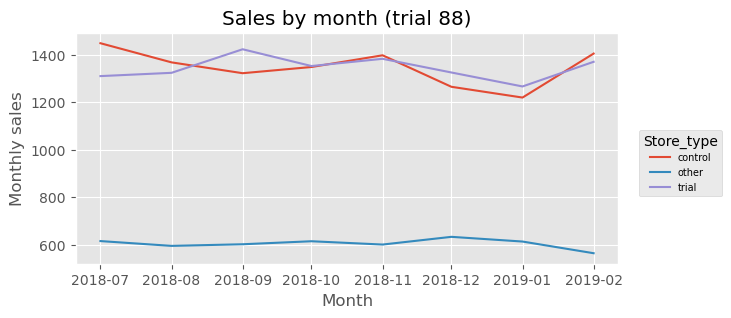

In [31]:
# View the selection by plotting sales and customers for the trial, control, and other stores
# 1. Sales
# Create categorical column for store_type with values trial, control, and other stores.

measure_over_time_trial88 = measure_over_time_df.copy()
measure_over_time_trial88['store_type'] = np.select(
    [measure_over_time_trial88['store_no'] == 88,
     measure_over_time_trial88['store_no'] == 237],
    ['trial', 'control'],
    default ='other'
)
# Convert date dtype to datetime

measure_over_time_trial88['year_month'] = pd.to_datetime(measure_over_time_trial88['year_month'], 
                                                         format='%Y%m')

# Remove values for periods during and after trial period

pre_trial_sales = measure_over_time_trial88[measure_over_time_trial88['year_month'] < '2019-03-01']

# Calculate the mean of sales of other stores

pre_trial_sales_df = pre_trial_sales.groupby(['store_type', 'year_month'])['totSales'].mean()\
                                                                        .reset_index()

# Plot trial, control, and mean sales

plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(7,3))

for store_type, group in pre_trial_sales_df.groupby('store_type'):
    ax.plot(group['year_month'], group['totSales'], label=store_type) 

ax.set_xlabel("Month")
ax.set_ylabel("Monthly sales")
ax.set_title("Sales by month (trial 88)")

plt.legend(bbox_to_anchor =(1.2, 0.6), fontsize=7, title='Store_type')

plt.show()

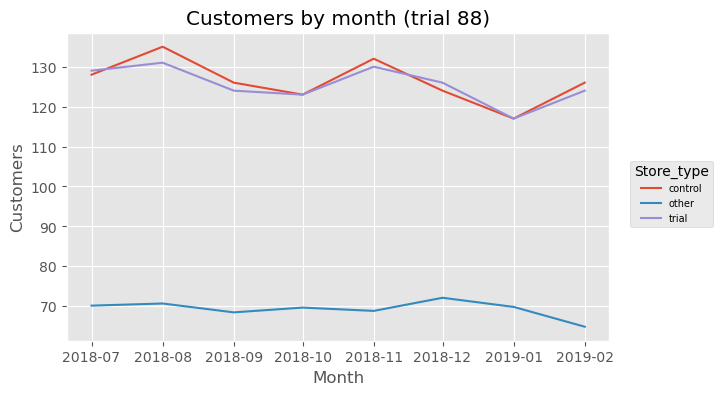

In [32]:
# 2. Customers

pre_trial_customers = pre_trial_sales.groupby(['store_type', 'year_month'])['nCustomers'].mean()\
                                                                        .reset_index()

# Plot trial, control, and other stores

fig, ax = plt.subplots(figsize=(7, 4))

for store_type, group in pre_trial_customers.groupby('store_type'):
    ax.plot(group['year_month'], group['nCustomers'], label=store_type)

ax.set_title("Customers by month (trial 88)")
ax.set_xlabel("Month")
ax.set_ylabel("Customers")
plt.legend(bbox_to_anchor=(1.2, 0.6), fontsize=7, title='Store_type')

plt.show()


### Assessing the impact of trial 88 on sales and customers

In [33]:
# Check the difference in the number of customers for trial 86 against its matched control 155
# Null hypothesis: No differences in the trial store sales and the control

# 1. Sales

# Scale control stores customers to smooth out differences outside the trial period
# Calculate scaling factor

scaling_factor = (measure_over_time_df[(measure_over_time_df['store_no']==88) & (measure_over_time_df['year_month'] < 
                '201902')]['totSales'].sum()) / (measure_over_time_df[(measure_over_time_df['store_no']==237) & 
                (measure_over_time_df['year_month'] < '201902')]['totSales'].sum())

# Calculate control sales by multiplying sales with the scaling factor.

scaled_control_sales = pd.DataFrame({
    'control_sales': measure_over_time_df[measure_over_time_df["store_no"]==237]['totSales']*scaling_factor,
    'store_no':237,
    'year_month': measure_over_time_df['year_month'].unique()})

scaled_control_sales_df = pd.merge(scaled_control_sales, measure_over_time_df[measure_over_time_df['store_no']==88], 
                                   on = 'year_month', suffixes=['_control', '_trial'])
scaled_control_sales_df['percent_diff'] = abs((scaled_control_sales_df['control_sales']-
                                             scaled_control_sales_df['totSales']) /
                                             scaled_control_sales_df['control_sales'])

# Calculate standard deviation to assess significant difference

std_dev = scaled_control_sales_df[scaled_control_sales_df['year_month'] < '201902']['percent_diff'].std()
print("standard deviation: ", std_dev)

# Calculate t-values for the percent_diff in the trial period

t_value_percent_diff = pd.DataFrame({
    "transaction_month": pd.to_datetime((scaled_control_sales_df[scaled_control_sales_df['year_month'].between(
        '201902', '201904', inclusive='both')]['year_month']), format='%Y%m'),
    't_value': scaled_control_sales_df[scaled_control_sales_df['year_month'].between(
        '201902', '201904', inclusive='both')]['percent_diff'].apply(lambda x: x/std_dev)
}).reset_index(drop=True)
print(t_value_percent_diff)
     
# Calculate the critical value for a right-tailed distribution of the percent_diff at 95% confidence to check
# if the t_values are significant

critical_t_value = st.t.ppf(0.95, 7)
print("Upper_bound: ", critical_t_value)

# The difference is sales between control and trial was not significant in two of the three months during the trial:
# as the t statistic is within the critical region in February and March.

standard deviation:  0.0334678673030788
  transaction_month   t_value
0        2019-02-01  0.781270
1        2019-03-01  6.595668
2        2019-04-01  5.768527
Upper_bound:  1.894578605061305


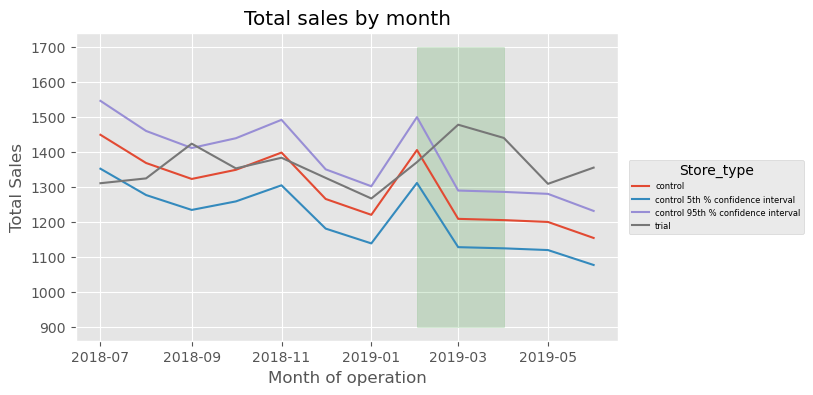

In [34]:
# Plot the sales for trial against the 95th and 5th percentile of the control to visualize differences

past_sales = measure_over_time_df.drop(['nCustomers', 'nTxnsPerCust','nChipsPerTxn', 
                                     'avgPricePerUnit'], axis=1)
# Insert store_type column
past_sales['store_type'] = np.select(
    [
        past_sales['store_no'] ==88,
        past_sales['store_no'] ==237
    ],
    ['trial', 'control'],
    default= 'other stores'
)

# Drop store_no column

past_sales = past_sales.drop("store_no", axis=1)

# Remove other stores 
past_sales = past_sales.loc[past_sales['store_type']!="other stores"]

# Change year_month dtype to datetime
past_sales['year_month'] = pd.to_datetime(past_sales['year_month'], format='%Y%m')

# Create 95th percentile sales for control store
ninety_fifth_percentile =pd.DataFrame({
    "store_type": "control 95th % confidence interval",
    "totSales": past_sales[past_sales["store_type"] == 'control']['totSales']*(1 +  std_dev*2),
    "year_month": past_sales[past_sales["store_type"] == 'control']['year_month'].unique()
})

# Create 5th percentile sales for control store
fifth_percentile = pd.DataFrame({
    "store_type": "control 5th % confidence interval",
     "totSales": past_sales[past_sales["store_type"] == 'control']['totSales']*(1 -  std_dev*2),
     "year_month": past_sales[past_sales["store_type"] == 'control']['year_month'].unique()
})

# Join the three dfs to create one df for plotting

past_sales_df = pd.concat([past_sales, ninety_fifth_percentile, fifth_percentile])

# Plot trial, control, and 95th and 5th percentile of the control store

from matplotlib.patches import Rectangle

rect = Rectangle((pd.to_datetime('2019-02-01'), 900), 
        width=pd.to_datetime('2019-04-01') - pd.to_datetime('2019-02-01'), 
        height=800, color='g', alpha=0.15)


fig, ax = plt.subplots(figsize=(7, 4))

for store_type, group in past_sales_df.groupby("store_type"):
    ax.plot(group["year_month"], group['totSales'], label = store_type)
    
ax.set_xlabel("Month of operation")
ax.set_ylabel("Total Sales")
ax.set_title("Total sales by month")
plt.legend(bbox_to_anchor=(1.35, 0.6), title="Store_type", fontsize=6)
plt.gca().add_patch(rect)

plt.show()


# The plot shows trial store 88 is significantly different from its control (store 237) as its average monthly
# sales exceed the 95th percentile of comparator store in two of the three months in the trial period.



In [35]:
# Check the difference in the number of customers for trial 86 against its matched control 155
# Null hypothesis: No impact on sales and number of customers

# 2. Customers

# Scale control stores customers to smooth out differences outside the trial period

# Calculate scaling factor
scaling_factor = measure_over_time_df[(measure_over_time_df['store_no']==88) & (measure_over_time_df['year_month'] < 
                '201902')]['nCustomers'].sum() / measure_over_time_df[(measure_over_time_df['store_no']==237) & 
                (measure_over_time_df['year_month'] < '201902')]['nCustomers'].sum()

# Calculate control customers by multiplying customers with the scaling factor.

scaled_control_customers = pd.DataFrame({
    'control_customers': measure_over_time_df[measure_over_time_df["store_no"]==237]['nCustomers']*scaling_factor,
    'store_no':237,
    'year_month': measure_over_time_df['year_month'].unique()})

scaled_control_customers_df = pd.merge(scaled_control_customers, measure_over_time_df[measure_over_time_df['store_no']==88], 
                                   on = 'year_month', suffixes=['_control', '_trial'])
scaled_control_customers_df['percent_diff'] = abs((scaled_control_customers_df['control_customers']-
                                             scaled_control_customers_df['nCustomers']) /
                                             scaled_control_customers_df['control_customers'])

# Calculate standard deviation to assess significant difference

std_dev = scaled_control_customers_df[scaled_control_customers_df['year_month'] < '201902']['percent_diff'].std()
print("standard deviation: ", std_dev)

# Calculate t-values for the percent_diff in the trial period

t_value_percent_diff = pd.DataFrame({
    "transaction_month": pd.to_datetime((scaled_control_customers_df[scaled_control_customers_df['year_month'].between(
        '201902', '201904', inclusive='both')]['year_month']).astype(str), format='%Y%m'),
    't_value': scaled_control_customers_df[scaled_control_customers_df['year_month'].between(
        '201902', '201904', inclusive='both')]['percent_diff'].apply(lambda x: x/std_dev)
}).reset_index(drop=True)
print(t_value_percent_diff)

# Calculate the critical value for a right-tailed distribution of the percent_diff at 95% confidence to check
# if the t_values are significant

critical_t_value = st.t.ppf(0.95, 7)
print("Upper_bound: ", critical_t_value)

# The difference in customers between control and trial was significant in two of three months during the trial:
# March and April 2019 as the t statistic is significantly outside the critical region.

standard deviation:  0.00741024435207507
  transaction_month    t_value
0        2019-02-01   1.387456
1        2019-03-01  17.873693
2        2019-04-01   9.814423
Upper_bound:  1.894578605061305


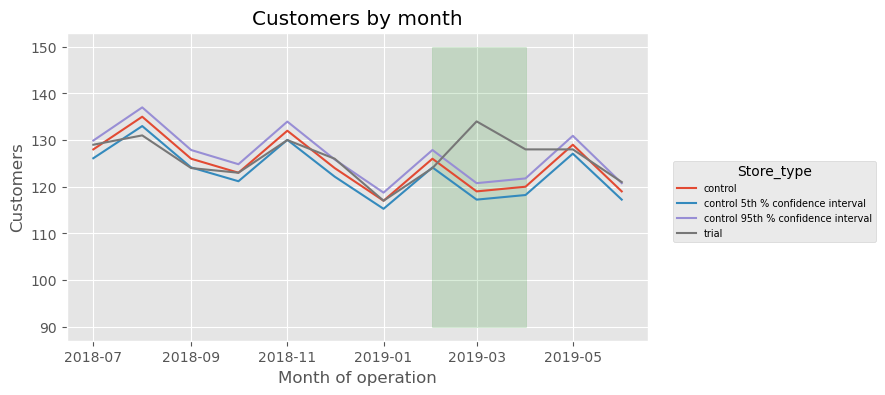

In [36]:
# Plot the customers for trial against the 95th and 5th percentile of the control to visualize differences

past_customers = measure_over_time_df.drop(['totSales', 'nTxnsPerCust','nChipsPerTxn', 
                                     'avgPricePerUnit'], axis=1)
# Insert store_type column
past_customers['store_type'] = np.select(
    [
        past_customers['store_no'] ==88,
        past_customers['store_no'] ==237
    ],
    ['trial', 'control'],
    default= 'other stores'
)

# Drop store_no column

past_customers = past_customers.drop("store_no", axis=1)

# Remove other stores 
past_customers = past_customers.loc[past_customers['store_type']!="other stores"]

# Change year_month dtype to datetime
past_customers['year_month'] = pd.to_datetime(past_customers['year_month'], format='%Y%m')

# Create 95th percentile sales for control store
ninety_fifth_percentile =pd.DataFrame({
    "store_type": "control 95th % confidence interval",
    "nCustomers": past_customers[past_customers["store_type"] == 'control']['nCustomers']*(1 +  std_dev*2),
    "year_month": past_customers[past_customers["store_type"] == 'control']['year_month'].unique()
})

# Create 5th percentile sales for control store
fifth_percentile = pd.DataFrame({
    "store_type": "control 5th % confidence interval",
     "nCustomers": past_customers[past_customers["store_type"] == 'control']['nCustomers']*(1 -  std_dev*2),
     "year_month": past_customers[past_customers["store_type"] == 'control']['year_month'].unique()
})

# Join the three dfs to create one df for plotting

past_customers_df = pd.concat([past_customers, ninety_fifth_percentile, fifth_percentile])

# Plot trial, control, and 95th and 5th percentile of the control store

from matplotlib.patches import Rectangle

rect = Rectangle((pd.to_datetime('2019-02-01'), 90), 
        width=pd.to_datetime('2019-04-01') - pd.to_datetime('2019-02-01'), 
        height= 60, color='g', alpha=0.15)


fig, ax = plt.subplots(figsize=(7.5, 4))

for store_type, group in past_customers_df.groupby("store_type"):
    ax.plot(group["year_month"], group['nCustomers'], label = store_type)
    
ax.set_xlabel("Month of operation")
ax.set_ylabel("Customers")
ax.set_title("Customers by month")
plt.legend(bbox_to_anchor=(1.40, 0.6), title="Store_type", fontsize=7)
plt.gca().add_patch(rect)

plt.show()


# The plot shows trial store 88 is significantly different from its control (store 237) as its average monthly
# customers exceed the 95th percentile of comparator store in two of the three months in the trial period. quired
# to explain the anormally.

